<a href="https://colab.research.google.com/github/vshukl01/Neurova_Shield/blob/main/4_mergedwithbreak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages if needed
!pip install pandas scikit-learn xgboost matplotlib seaborn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, r2_score, mean_absolute_error, mean_squared_error # Import necessary metrics
from sklearn.multioutput import MultiOutputClassifier # Import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier # Import MLPClassifier


In [ ]:
# Load the merged dataset (upload to Colab session or mount Google Drive)
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/WESAD/df_files/all_subjects_labeled_final.csv'  # Update if needed
df = pd.read_csv(file_path)
print(f"Loaded data with shape: {df.shape}")
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded data with shape: (106804, 56)


,index,timestamp,ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,HR,height_cm,...,I feel pleasant,Valence,Arousal,Committed to goals,Wanted to succeed,Motivated,Reflected about self,Worried what others think,Concerned about impression,Subject_No
0,NaN,2017-07-25 07:05:08,5.438,0.938,63.000,15.760,0.202,382.21,71.00,178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10
1,NaN,2017-07-25 07:05:09,5.188,0.969,62.906,-41.960,0.295,31.19,71.00,178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10
2,NaN,2017-07-25 07:05:10,5.188,0.969,63.000,26.183,0.293,31.19,70.67,178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10
3,NaN,2017-07-25 07:05:11,5.312,0.969,62.969,0.891,0.295,31.19,71.25,178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10
4,NaN,2017-07-25 07:05:12,5.438,0.844,62.719,2.827,0.293,31.17,72.20,178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S10


In [ ]:
EMOTION_COLS = [
    'Active', 'Distressed', 'Interested', 'Inspired', 'Annoyed', 'Strong',
    'Guilty', 'Scared', 'Hostile', 'Excited', 'Proud', 'Irritable',
    'Enthusiastic', 'Ashamed', 'Alert', 'Nervous', 'Determined', 'Attentive',
    'Jittery', 'Afraid', 'Stressed', 'Frustrated', 'Happy', 'Sad',
    'I feel at ease', 'I feel nervous', 'I am jittery', 'I am relaxed',
    'I am worried', 'I feel pleasant'
]

MOTIVATION_COLS = [
    'Committed to goals', 'Wanted to succeed', 'Motivated',
    'Reflected about self', 'Worried what others think',
    'Concerned about impression'
]

E4_FEATURES = ['ACC_x', 'ACC_y', 'ACC_z', 'BVP', 'EDA', 'TEMP', 'HR']



In [ ]:
#Load and prepare entire dataset with condition and gender
def load_all_conditions_data(file_path):
    print("Loading data from:", file_path)
    df = pd.read_csv(file_path)
    print("Initial dataset shape:", df.shape)
    df['Condition'] = df['Condition'].fillna('break').str.strip().str.lower()
    df['gender'] = df['gender'].str.strip().str.lower()
    df['Condition'] = df['Condition'].replace({'tsst': 'stress', 'medi1': 'meditation', 'medi2': 'meditation'})
    for col in MOTIVATION_COLS:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    print("Data loaded and cleaned. Final shape:", df.shape)
    return df


In [ ]:
# Prepare feature and target sets including condition and gender
def prepare_features_and_targets(df, e4_features, emotion_cols):
    print("Preparing features and targets...")
    grouped = df.groupby(['Subject_No', 'Condition'])
    all_X, all_y = [], []
    skipped_breaks = 0
    skipped_empty = 0
    included = 0

    for (_, condition), group in grouped:
        if condition == 'break':
            skipped_breaks += 1
            continue
        try:
            emotion_vector = group[emotion_cols].dropna().iloc[0]
        except IndexError:
            skipped_empty += 1
            continue
        features = group[e4_features].dropna()
        if features.empty:
            skipped_empty += 1
            continue
        label_values = emotion_vector.values.tolist()
        condition_label = group['Condition'].iloc[0]
        gender_label = group['gender'].iloc[0]
        labels = pd.DataFrame([label_values + [condition_label, gender_label]] * len(features),
                              columns=emotion_cols + ['Condition', 'Gender'])
        all_X.append(features)
        all_y.append(labels)
        included += len(features)

    final_X = pd.concat(all_X, ignore_index=True)
    final_y = pd.concat(all_y, ignore_index=True)
    print(f"Skipped {skipped_breaks} break periods and {skipped_empty} empty groups")
    print(f"Prepared {included} rows of features and {final_y.shape[1]} target columns")
    return final_X, final_y


In [ ]:
# Train and evaluate multiple models
def evaluate_models(X, y):
    print("Encoding targets using LabelEncoder")
    y_encoded = y.copy()
    label_encoders = {}

    for col in y_encoded.columns:
        le = LabelEncoder()
        y_encoded[col] = le.fit_transform(y_encoded[col])
        label_encoders[col] = le

    print("Splitting data into train and test sets")
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss'),
        'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
    }

    results = []
    for name, base_model in models.items():
        print(f"Training model: {name}")
        model = MultiOutputClassifier(base_model)
        model.fit(X_train, y_train)
        print(f"Evaluating model: {name}")
        y_pred = model.predict(X_test)

        if 'Condition' in y.columns:
            condition_index = y.columns.get_loc('Condition')
            condition_accuracy = np.mean(y_pred[:, condition_index] == y_test.iloc[:, condition_index]) * 100
            print(f"{name} model accuracy for Condition prediction: {condition_accuracy:.2f}%")

        if 'Gender' in y.columns:
            gender_index = y.columns.get_loc('Gender')
            gender_accuracy = np.mean(y_pred[:, gender_index] == y_test.iloc[:, gender_index]) * 100
            print(f"{name} model accuracy for Gender prediction: {gender_accuracy:.2f}%")

        for i, column in enumerate(y_test.columns):
            r2 = r2_score(y_test.iloc[:, i], y_pred[:, i]) * 100
            mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) * 100
            rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) * 100
            print(f"{name} | {column:>25}: R2={r2:.2f}%  MAE={mae:.2f}%  RMSE={rmse:.2f}%")
            results.append({"Model": name, "Target": column, "R2": r2, "MAE": mae, "RMSE": rmse})

    print("Model evaluation complete.")
    return pd.DataFrame(results)



In [ ]:
# Run all-condition model comparisons
print("Starting pipeline...")
df_all = load_all_conditions_data(file_path)
X_all, y_all = prepare_features_and_targets(df_all, E4_FEATURES, EMOTION_COLS)
results_df = evaluate_models(X_all, y_all)

Starting pipeline...
Loading data from: /content/drive/MyDrive/WESAD/df_files/all_subjects_labeled_final.csv
Initial dataset shape: (106804, 56)
Data loaded and cleaned. Final shape: (106804, 56)
Preparing features and targets...
Skipped 15 break periods and 1 empty groups
Prepared 46017 rows of features and 32 target columns
Encoding targets using LabelEncoder
Splitting data into train and test sets
Training model: RandomForest
Evaluating model: RandomForest
RandomForest model accuracy for Condition prediction: 99.15%
RandomForest model accuracy for Gender prediction: 99.73%
RandomForest |                    Active: R2=98.80%  MAE=0.75%  RMSE=13.87%
RandomForest |                Distressed: R2=99.15%  MAE=0.39%  RMSE=6.59%
RandomForest |                Interested: R2=98.87%  MAE=0.66%  RMSE=10.88%
RandomForest |                  Inspired: R2=98.79%  MAE=0.72%  RMSE=11.61%
RandomForest |                   Annoyed: R2=98.08%  MAE=0.40%  RMSE=8.14%
RandomForest |                    Stron

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Evaluating model: XGBoost
XGBoost model accuracy for Condition prediction: 98.25%
XGBoost model accuracy for Gender prediction: 99.71%
XGBoost |                    Active: R2=97.62%  MAE=1.59%  RMSE=19.56%
XGBoost |                Distressed: R2=98.53%  MAE=0.73%  RMSE=8.66%
XGBoost |                Interested: R2=97.95%  MAE=1.29%  RMSE=14.63%
XGBoost |                  Inspired: R2=96.88%  MAE=2.02%  RMSE=18.65%
XGBoost |                   Annoyed: R2=98.68%  MAE=0.37%  RMSE=6.76%
XGBoost |                    Strong: R2=97.86%  MAE=1.36%  RMSE=14.48%
XGBoost |                    Guilty: R2=98.64%  MAE=0.15%  RMSE=5.11%
XGBoost |                    Scared: R2=98.30%  MAE=0.73%  RMSE=11.37%
XGBoost |                   Hostile: R2=97.57%  MAE=0.20%  RMSE=7.07%
XGBoost |                   Excited: R2=96.15%  MAE=2.82%  RMSE=22.84%
XGBoost |                     Proud: R2=97.46%  MAE=1.05%  RMSE=12.29%
XGBoost |                 Irritable: R2=98.61%  MAE=0.63%  RMSE=9.21%
XGBoost |         

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating model: MLP
MLP model accuracy for Condition prediction: 79.68%
MLP model accuracy for Gender prediction: 96.00%
MLP |                    Active: R2=57.36%  MAE=28.12%  RMSE=82.75%
MLP |                Distressed: R2=68.17%  MAE=11.06%  RMSE=40.34%
MLP |                Interested: R2=61.61%  MAE=23.62%  RMSE=63.37%
MLP |                  Inspired: R2=51.83%  MAE=29.37%  RMSE=73.27%
MLP |                   Annoyed: R2=74.99%  MAE=5.55%  RMSE=29.35%
MLP |                    Strong: R2=64.85%  MAE=20.99%  RMSE=58.74%
MLP |                    Guilty: R2=43.37%  MAE=6.66%  RMSE=32.98%
MLP |                    Scared: R2=71.36%  MAE=12.06%  RMSE=46.73%
MLP |                   Hostile: R2=69.09%  MAE=3.32%  RMSE=25.19%
MLP |                   Excited: R2=60.33%  MAE=28.38%  RMSE=73.28%
MLP |                     Proud: R2=49.37%  MAE=18.68%  RMSE=54.87%
MLP |                 Irritable: R2=70.84%  MAE=10.59%  RMSE=42.12%
MLP |              Enthusiastic: R2=61.34%  MAE=20.95%  RMSE=57.

In [ ]:
# Summary Table
pivot_table = results_df.pivot_table(index='Target', columns='Model', values='R2')
print("Summary R² Table (%):")
print(pivot_table.round(2))

Summary R² Table (%):
Model              MLP  RandomForest  XGBoost
Target                                       
Active           57.36         98.80    97.62
Afraid           65.06         99.18    98.06
Alert            49.72         98.60    97.67
Annoyed          74.99         98.08    98.68
Ashamed          69.13         98.53    98.90
Attentive        46.36         98.19    96.78
Condition        61.34         97.85    96.51
Determined       50.56         97.99    96.50
Distressed       68.17         99.15    98.53
Enthusiastic     61.34         98.88    97.10
Excited          60.33         98.57    96.15
Frustrated       70.82         98.68    98.55
Gender           75.49         98.33    98.20
Guilty           43.37         98.64    98.64
Happy            51.98         97.74    96.16
Hostile          69.09         97.04    97.57
I am jittery     65.09         98.69    95.51
I am relaxed     66.90         99.01    97.97
I am worried     69.70         98.21    96.94
I feel at ea

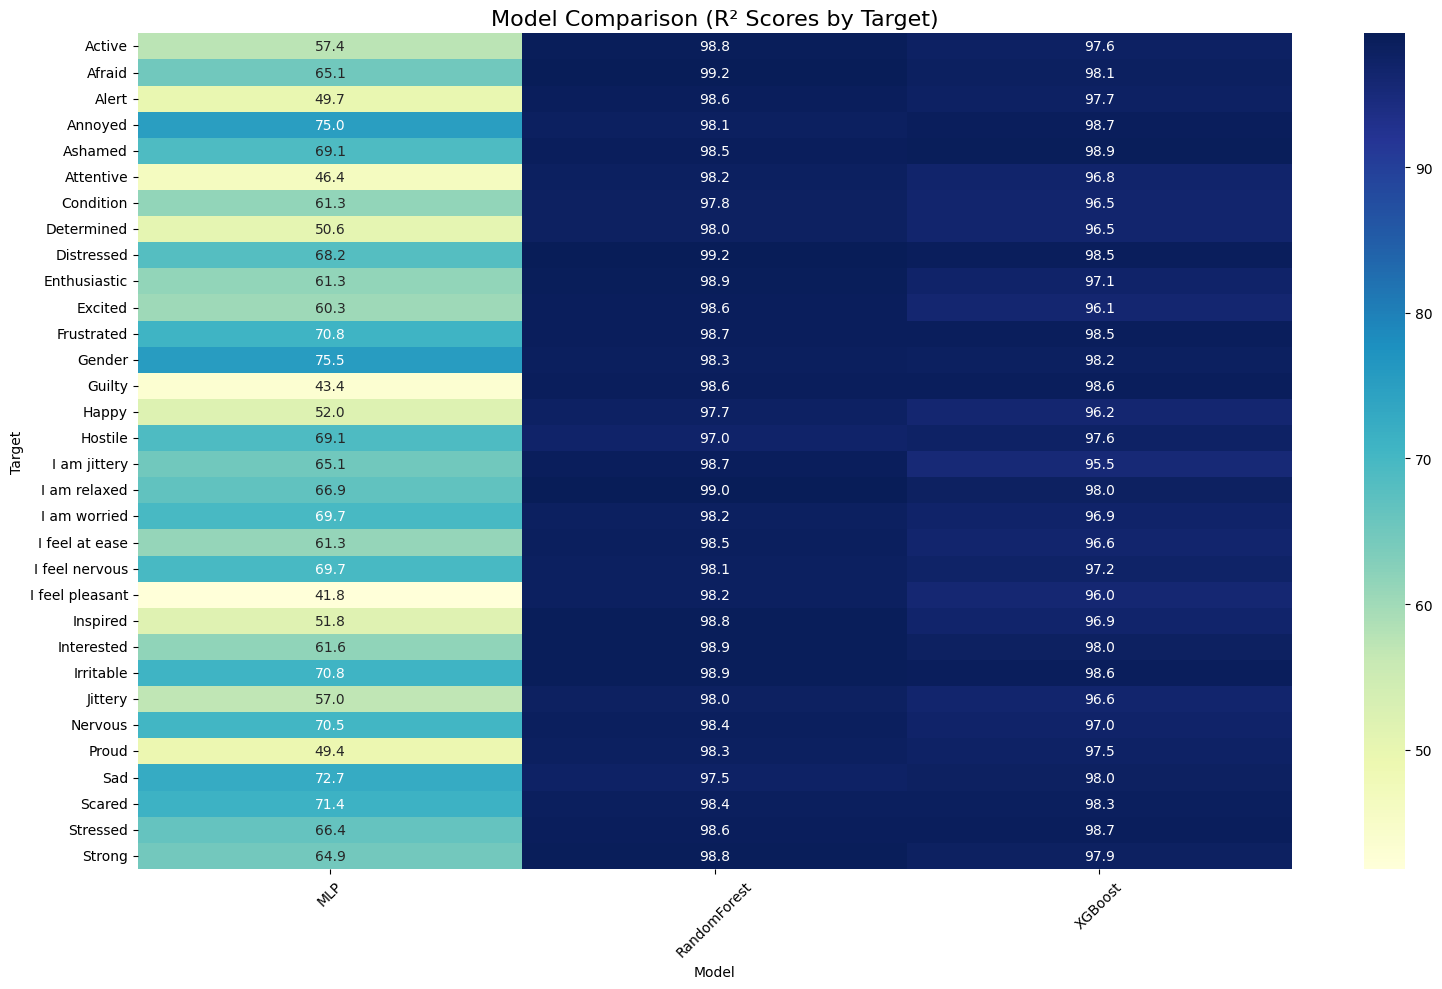

In [ ]:

# Plot performance comparison
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Model Comparison (R² Scores by Target)", fontsize=16)
plt.ylabel("Target")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


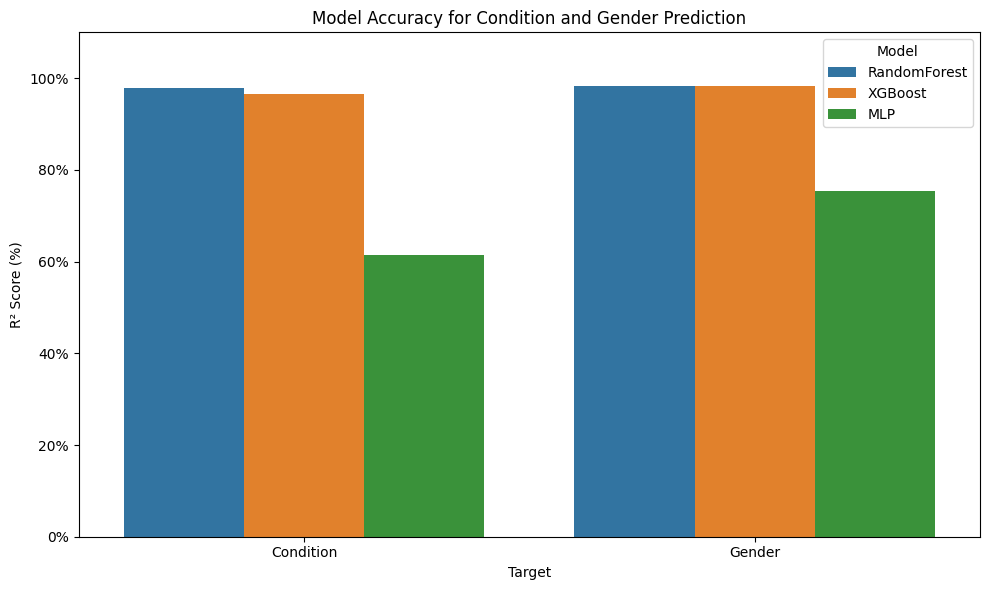

In [ ]:
# Bar plots for Condition and Gender accuracy by model
import matplotlib.ticker as mtick
accuracy_df = results_df[results_df['Target'].isin(['Condition', 'Gender'])]
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_df, x='Target', y='R2', hue='Model')
plt.title("Model Accuracy for Condition and Gender Prediction")
plt.ylabel("R² Score (%)")
plt.xlabel("Target")
plt.ylim(0, 110)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Model")
plt.tight_layout()
plt.show()

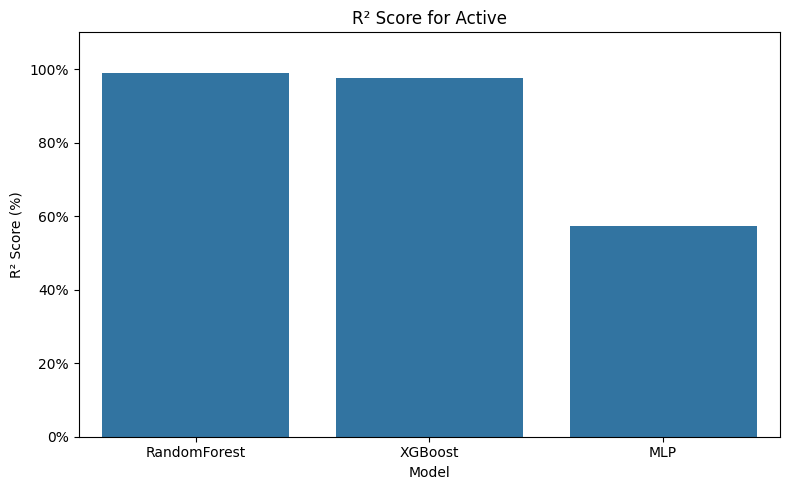

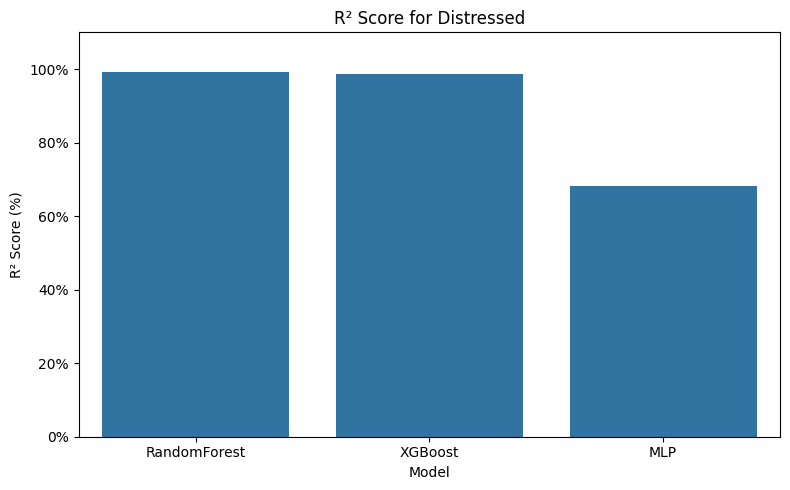

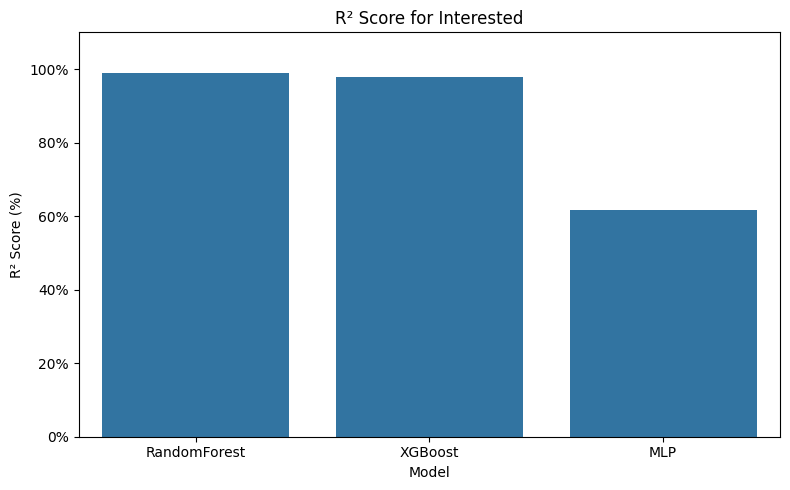

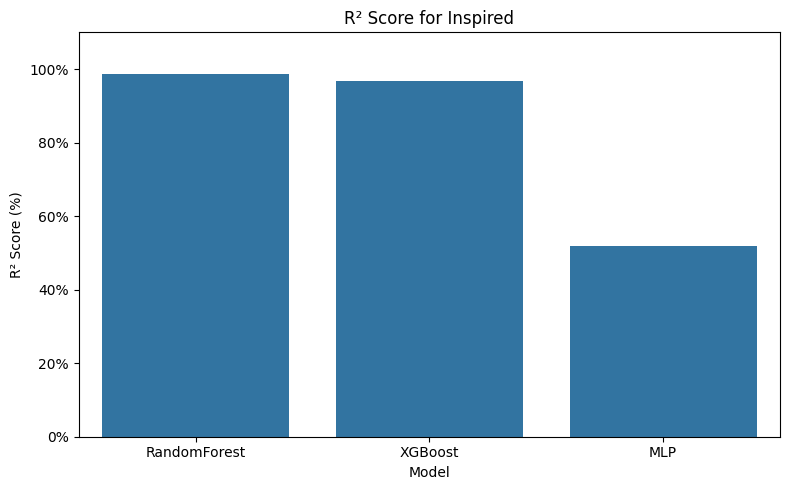

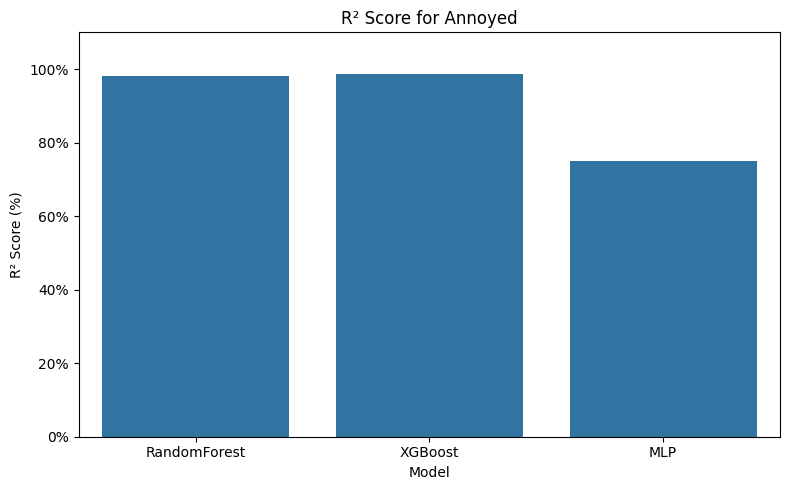

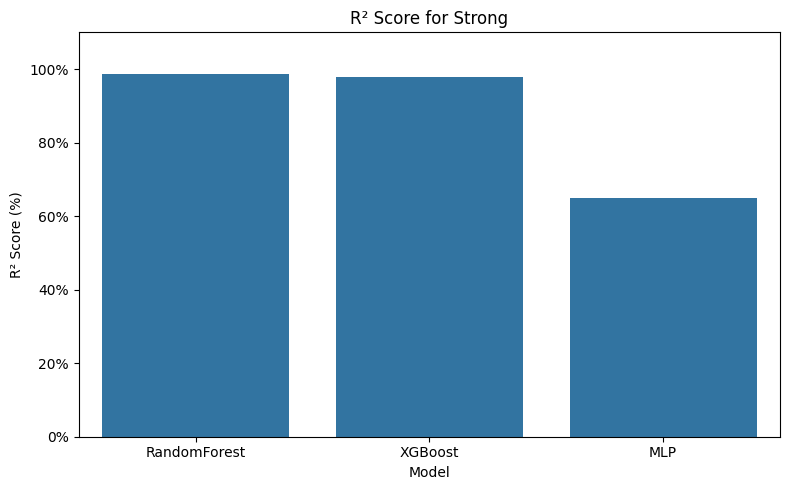

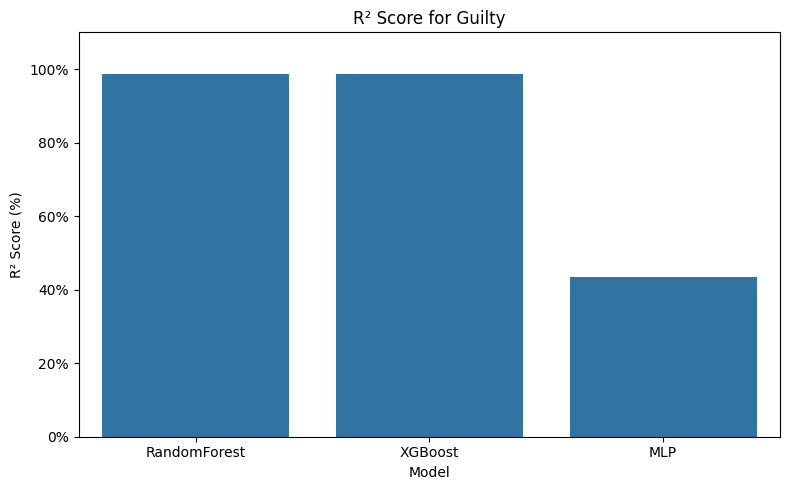

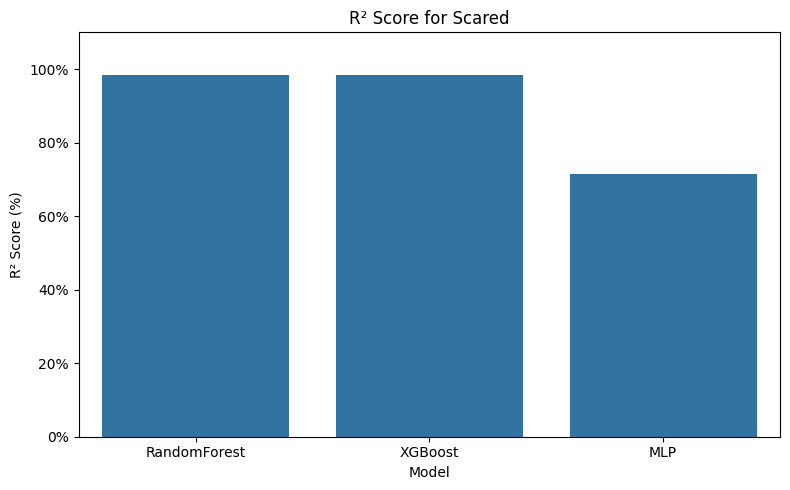

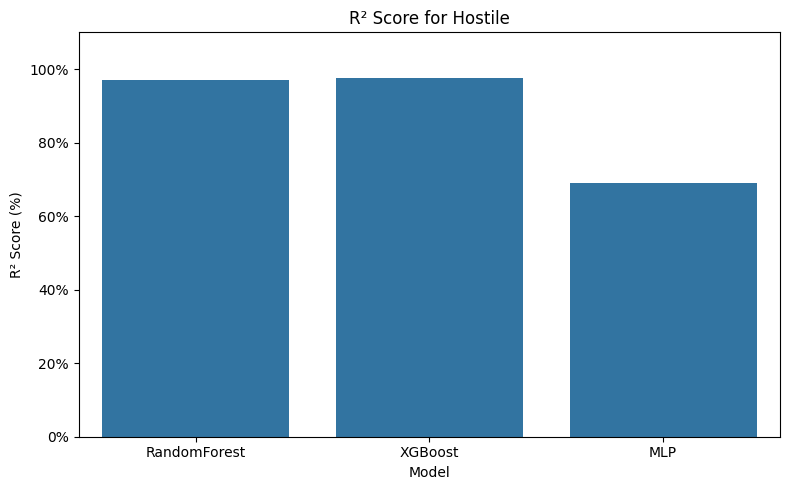

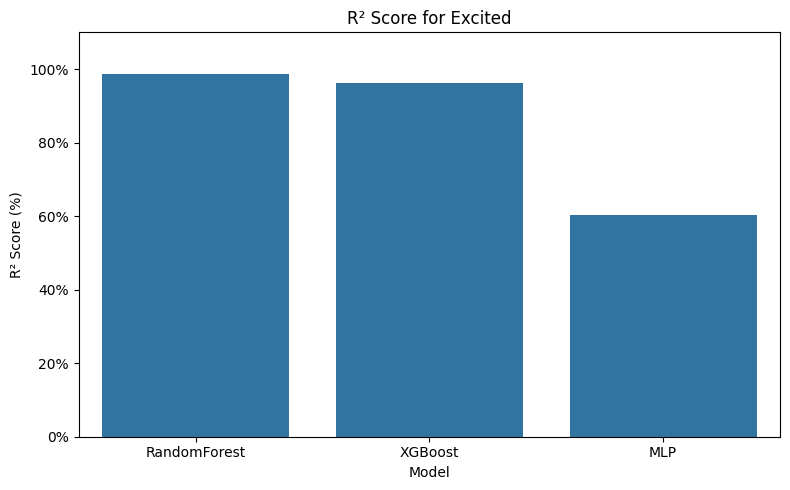

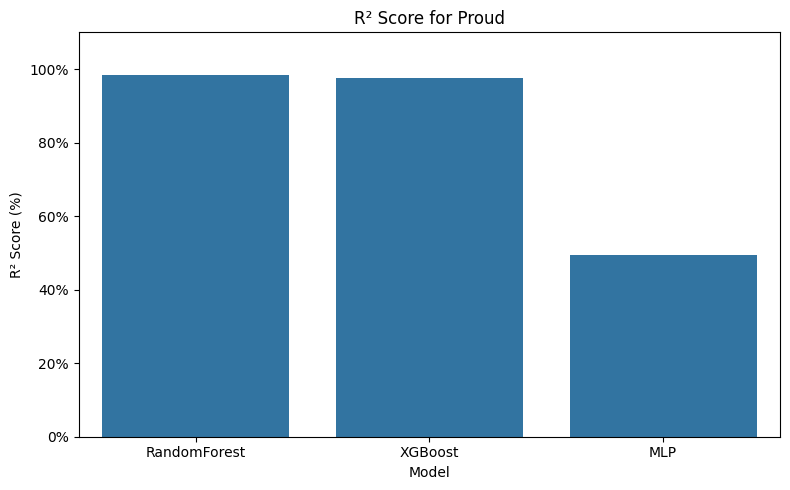

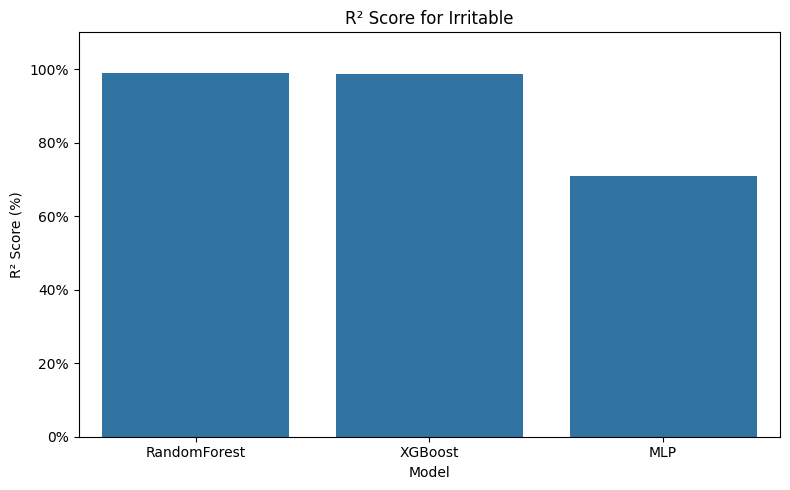

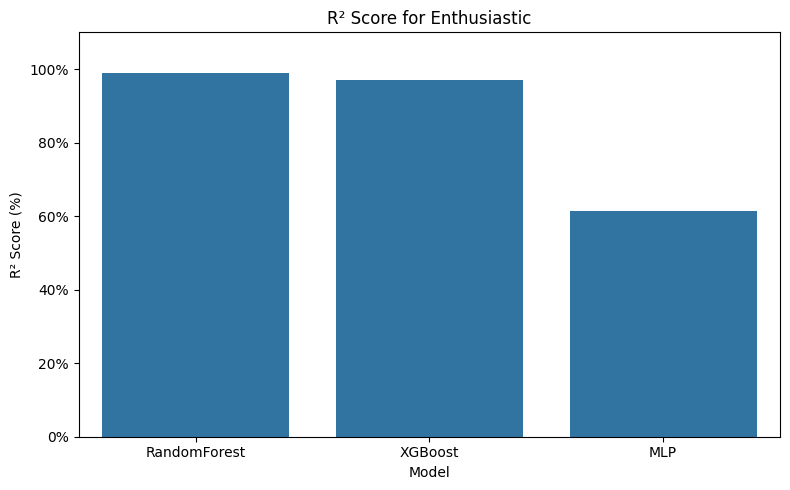

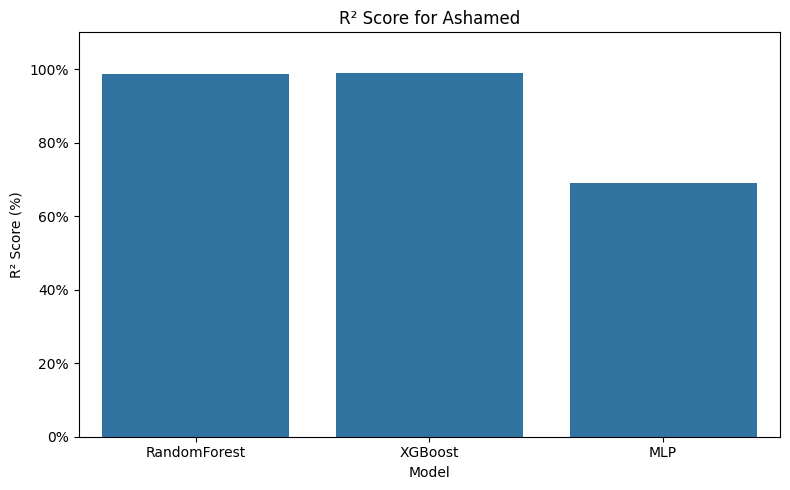

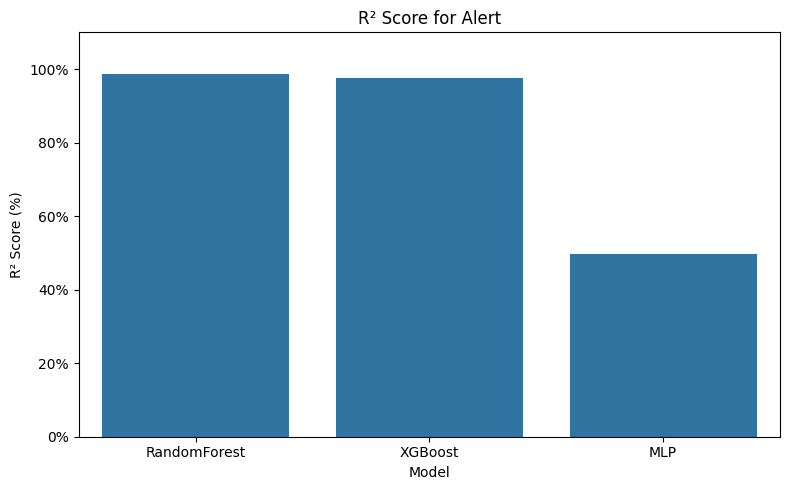

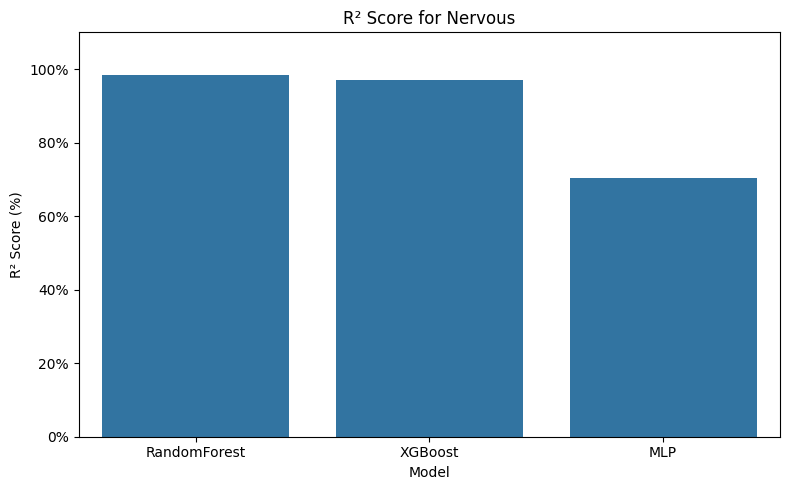

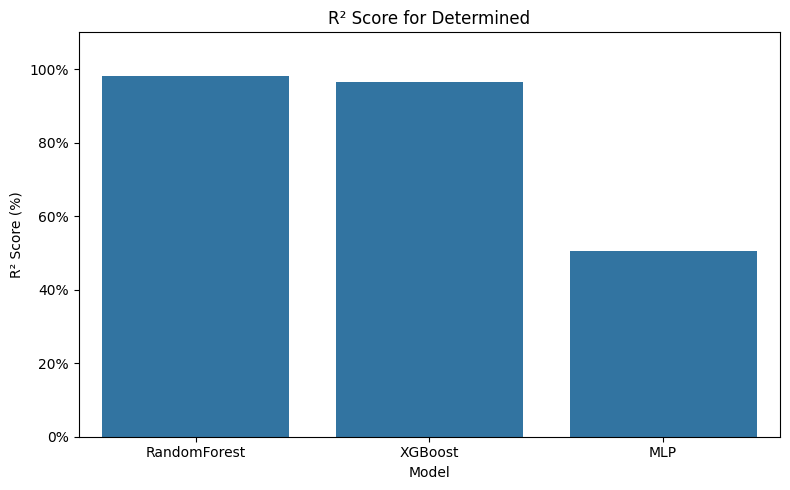

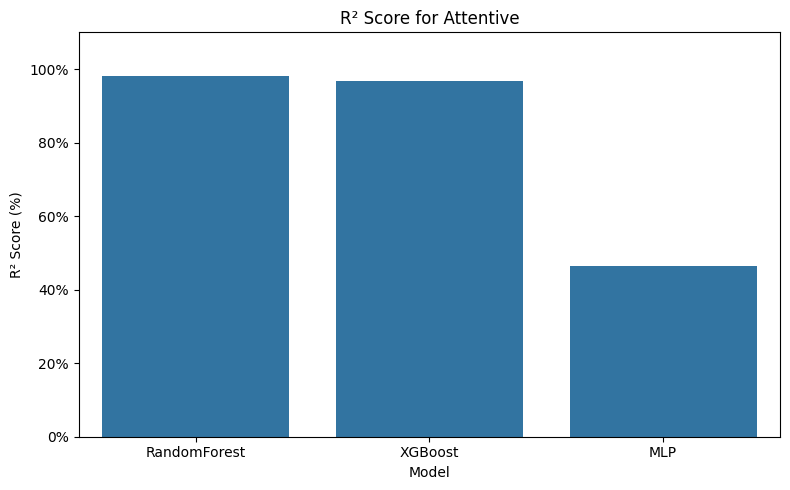

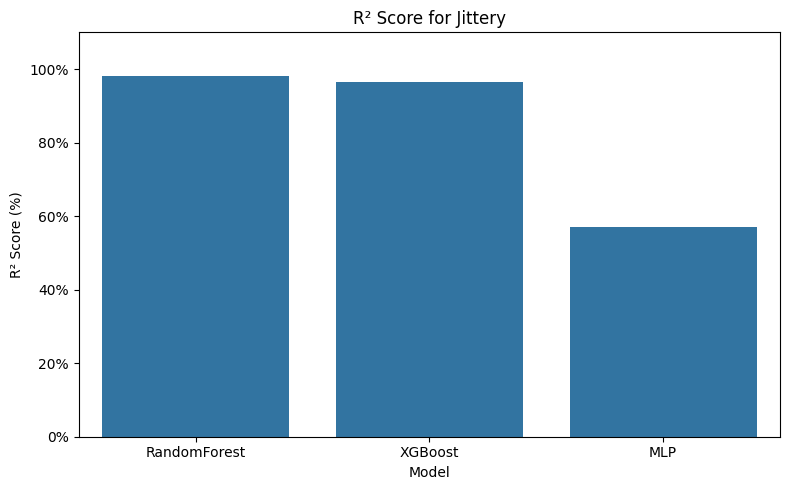

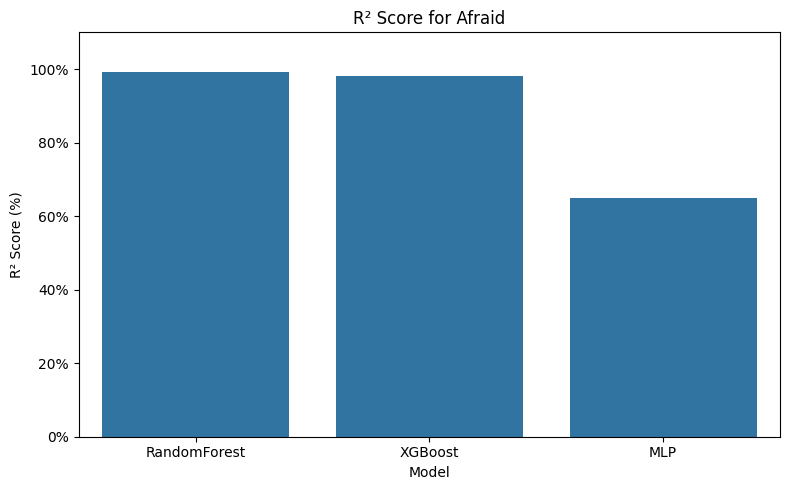

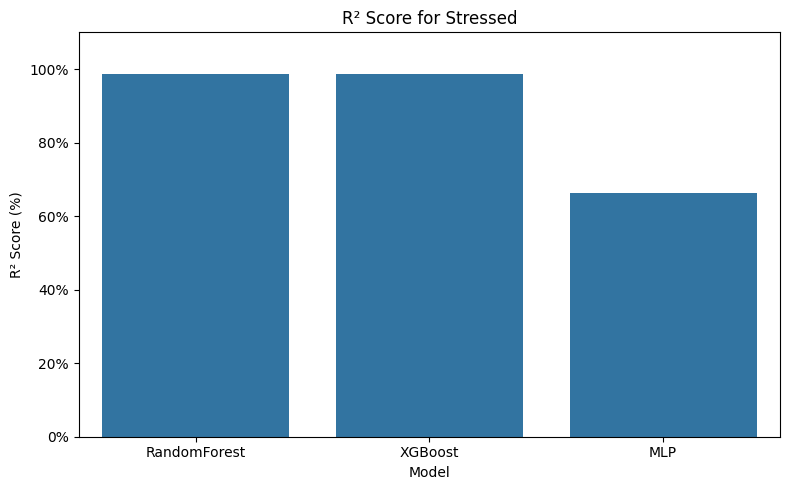

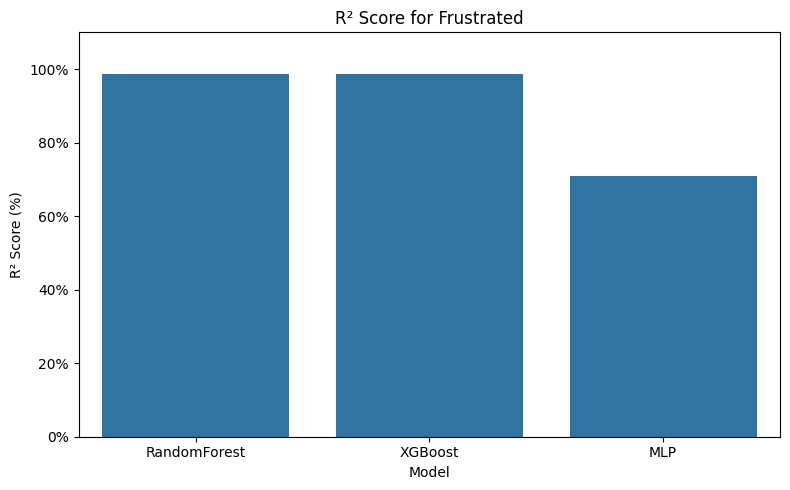

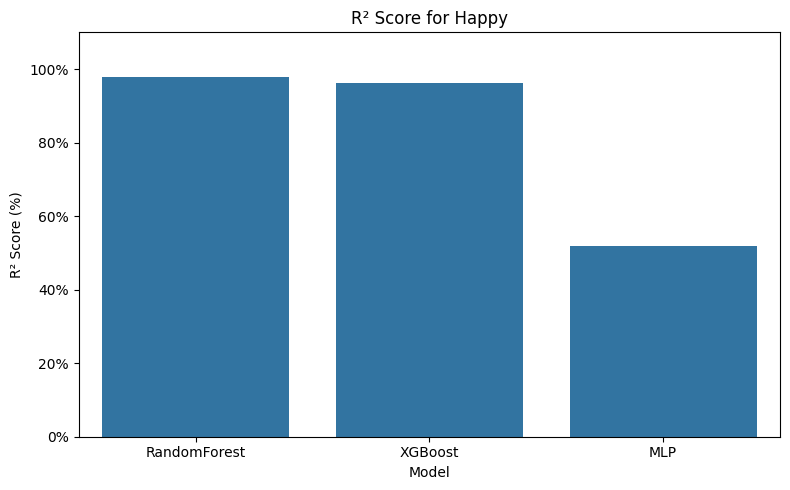

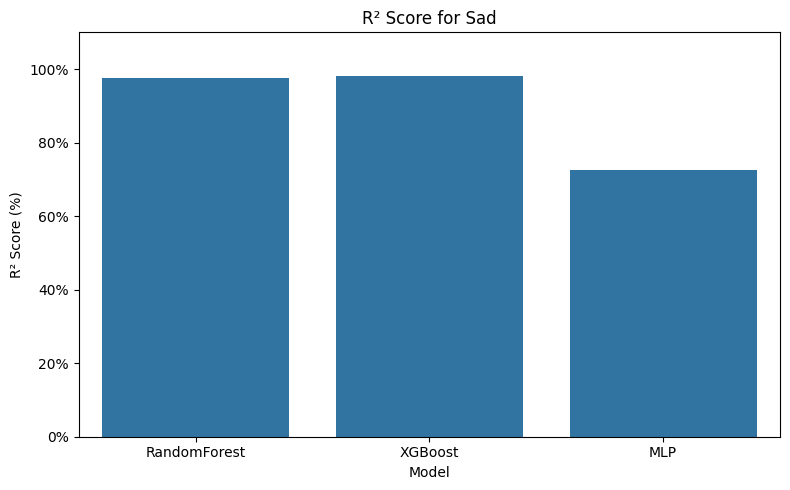

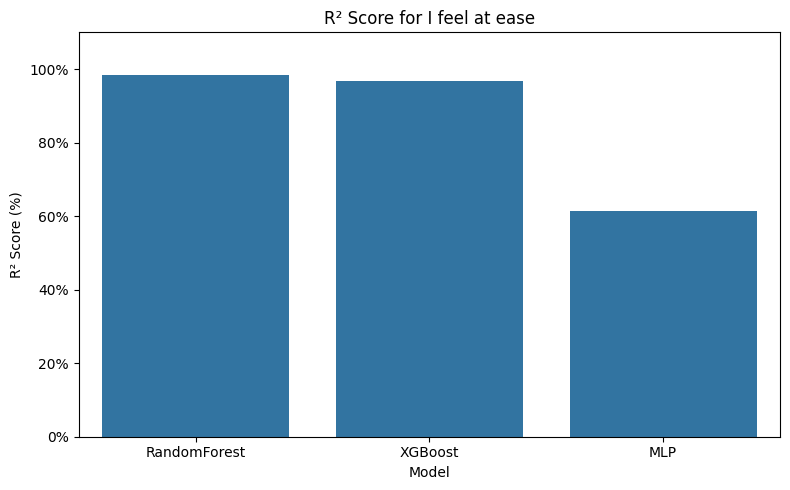

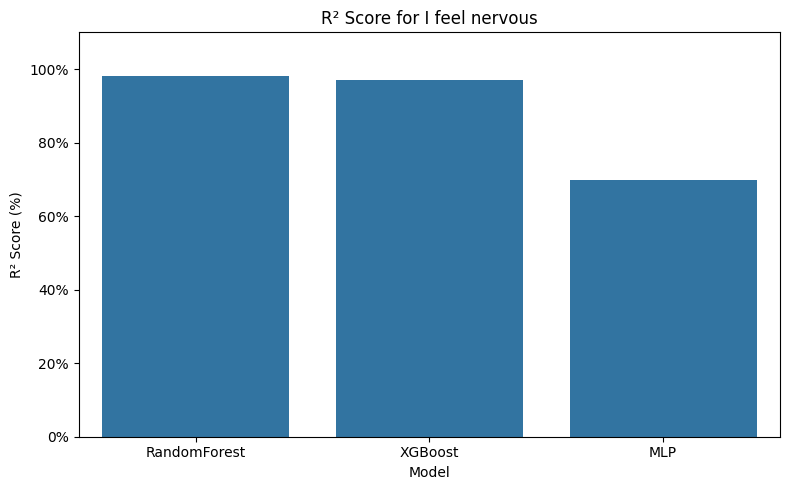

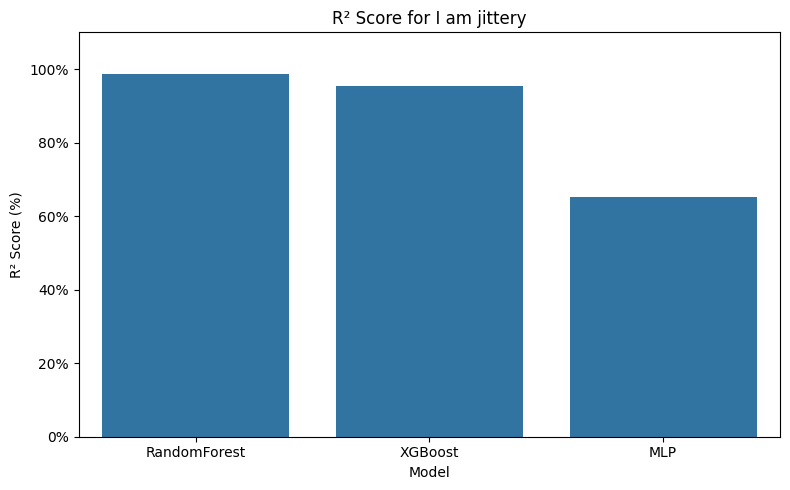

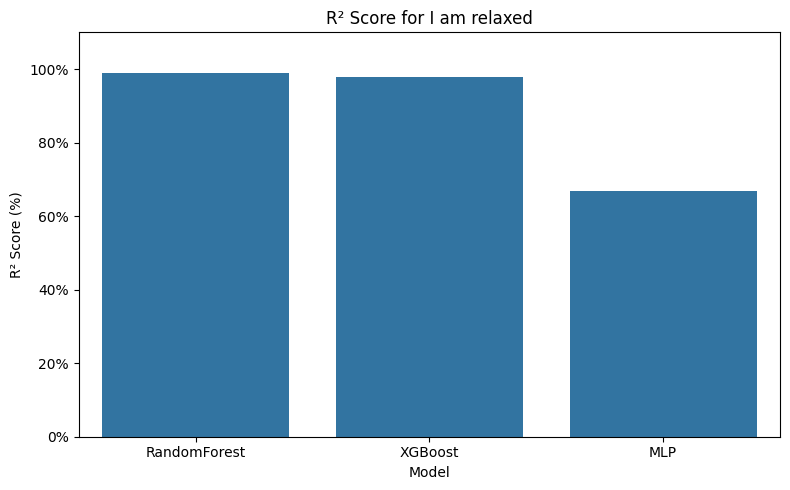

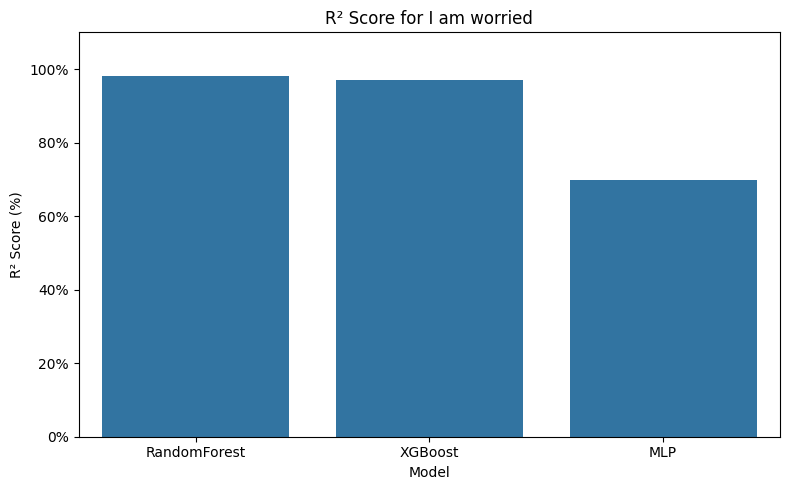

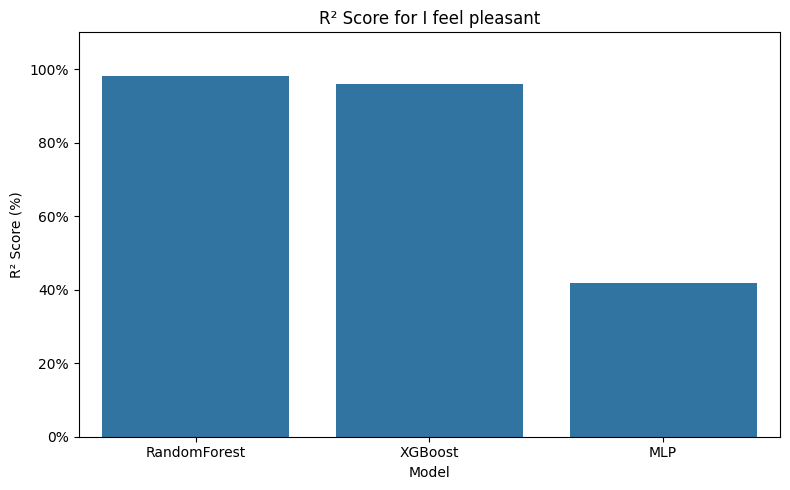

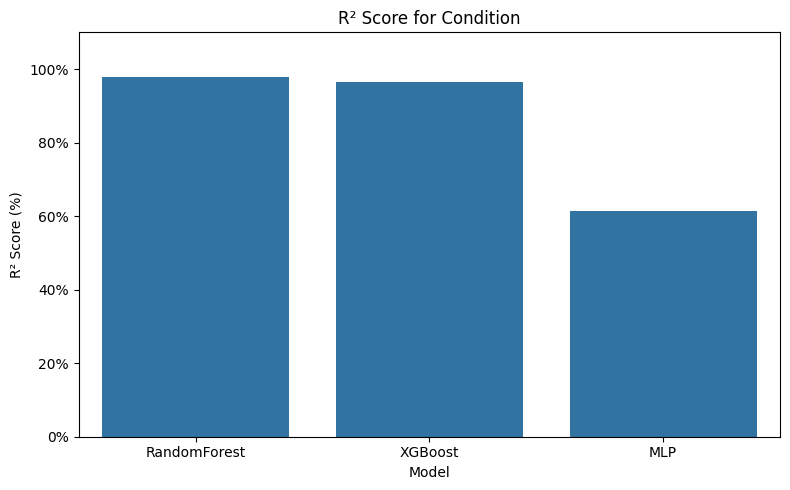

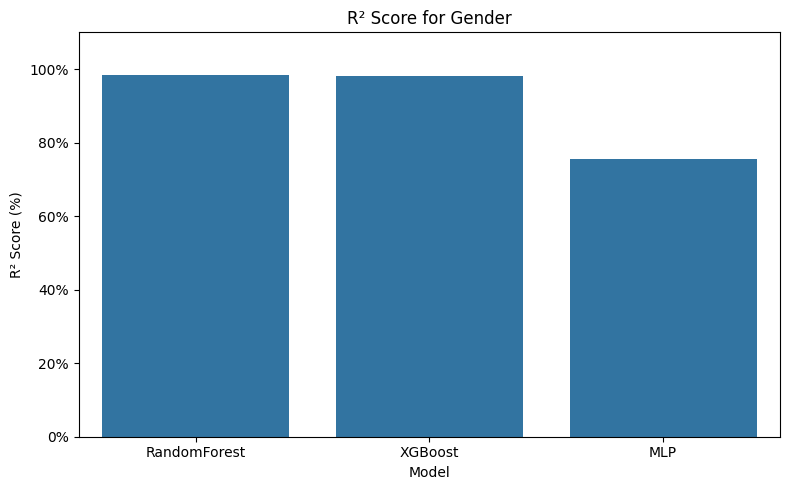

In [ ]:
# Actual vs Predicted plots for all targets
all_targets = results_df['Target'].unique()
for target in all_targets:
    subset = results_df[results_df['Target'] == target]
    if not subset.empty:
        plt.figure(figsize=(8, 5))
        sns.barplot(data=subset, x='Model', y='R2')
        plt.title(f"R² Score for {target}")
        plt.ylabel("R² Score (%)")
        plt.ylim(0, 110)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.xlabel("Model")
        plt.tight_layout()
        plt.show()

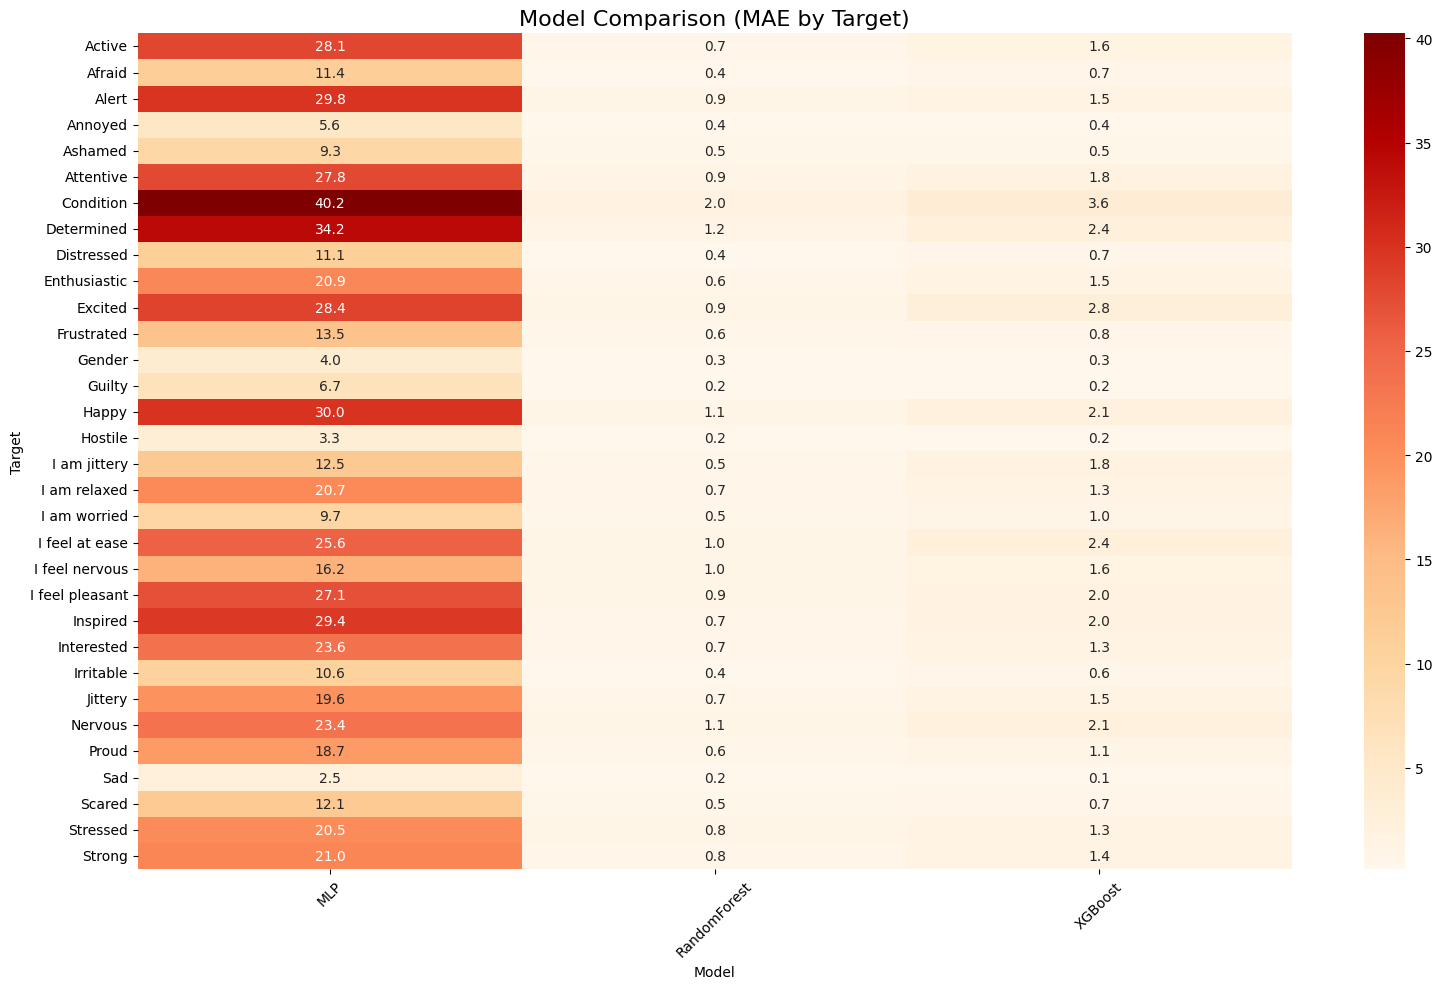

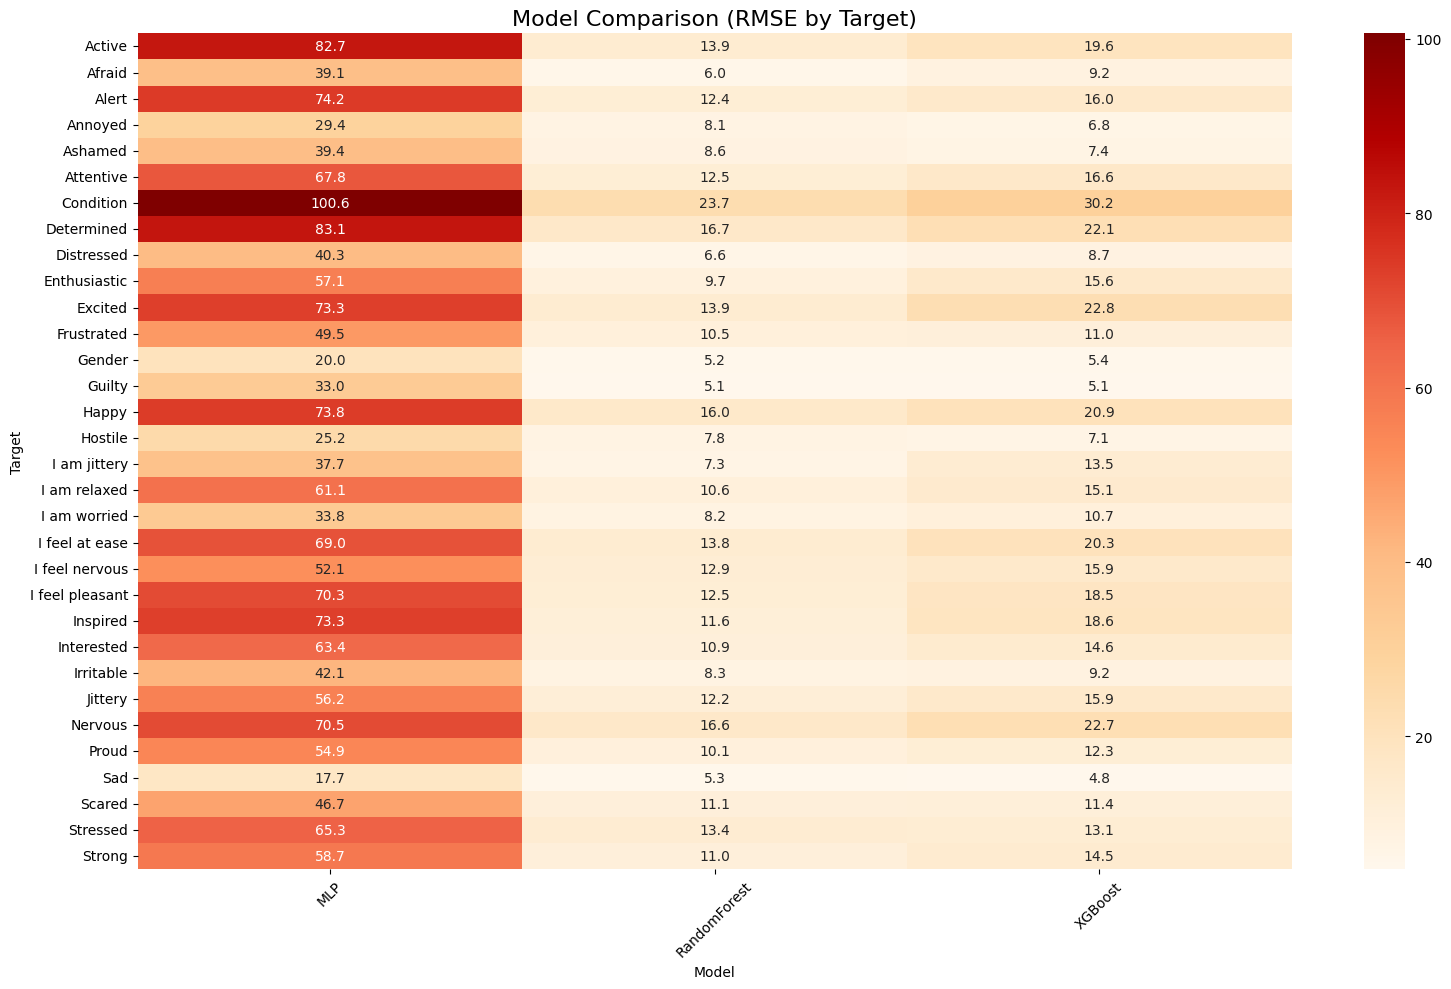

In [ ]:
# Heatmap for MAE and RMSE
for metric in ['MAE', 'RMSE']:
    metric_table = results_df.pivot_table(index='Target', columns='Model', values=metric)
    plt.figure(figsize=(16, 10))
    sns.heatmap(metric_table, annot=True, fmt=".1f", cmap="OrRd")
    plt.title(f"Model Comparison ({metric} by Target)", fontsize=16)
    plt.ylabel("Target")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
# Load Sub2 data and run prediction (RandomForest & XGBoost)
sub2_df = df_all[df_all['Subject_No'].str.lower() == 's2'].copy()
sub2_features = sub2_df[E4_FEATURES].dropna().reset_index(drop=True)

from sklearn.preprocessing import LabelEncoder
le_condition = LabelEncoder()
y_condition = le_condition.fit_transform(y_all['Condition'])

# RandomForest model
print("Training RandomForestClassifier to predict Condition only...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_all, y_condition)
print("Predicting conditions for Subject S2 using RandomForest...")
rf_pred = rf_model.predict(sub2_features)
rf_condition_pred = pd.Series(le_condition.inverse_transform(rf_pred), name='RF_Predicted_Condition')

# XGBoost model
print("Training XGBoostClassifier to predict Condition only...")
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax')
xgb_model.fit(X_all, y_condition)
print("Predicting conditions for Subject S2 using XGBoost...")
xgb_pred = xgb_model.predict(sub2_features)
xgb_condition_pred = pd.Series(le_condition.inverse_transform(xgb_pred), name='XGB_Predicted_Condition')


Training RandomForestClassifier to predict Condition only...
Predicting conditions for Subject S2 using RandomForest...
Training XGBoostClassifier to predict Condition only...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Predicting conditions for Subject S2 using XGBoost...


In [ ]:
# Identify segment transitions in predicted conditions
print("Training MLPClassifier to predict Condition only...")
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_all, y_condition)
print("Predicting conditions for Subject S2 using MLP...")
mlp_pred = mlp_model.predict(sub2_features)
mlp_condition_pred = pd.Series(le_condition.inverse_transform(mlp_pred), name='MLP_Predicted_Condition')

def extract_segments(predictions):
    transitions = []
    start_idx = 0
    current = predictions.iloc[0]
    for idx in range(1, len(predictions)):
        if predictions.iloc[idx] != current:
            transitions.append((current, start_idx, idx - 1))
            current = predictions.iloc[idx]
            start_idx = idx
    transitions.append((current, start_idx, len(predictions) - 1))
    return transitions

print("Predicted segments for Subject S2 (RandomForest):")
rf_segments = extract_segments(rf_condition_pred)
for label, start, end in rf_segments:
    print(f"Condition: {label:12} | Start Index: {start:5} | End Index: {end:5}")

print("Predicted segments for Subject S2 (XGBoost):")
xgb_segments = extract_segments(xgb_condition_pred)
for label, start, end in xgb_segments:
    print(f"Condition: {label:12} | Start Index: {start:5} | End Index: {end:5}")

print("Predicted segments for Subject S2 (MLP):")
mlp_segments = extract_segments(mlp_condition_pred)
for label, start, end in mlp_segments:
    print(f"Condition: {label:12} | Start Index: {start:5} | End Index: {end:5}")



Training MLPClassifier to predict Condition only...
Predicting conditions for Subject S2 using MLP...
Predicted segments for Subject S2 (RandomForest):
Condition: stress       | Start Index:     0 | End Index:     0
Condition: medi 1       | Start Index:     1 | End Index:     3
Condition: base         | Start Index:     4 | End Index:     4
Condition: medi 1       | Start Index:     5 | End Index:     5
Condition: stress       | Start Index:     6 | End Index:     7
Condition: base         | Start Index:     8 | End Index:    12
Condition: stress       | Start Index:    13 | End Index:    38
Condition: base         | Start Index:    39 | End Index:   281
Condition: stress       | Start Index:   282 | End Index:   291
Condition: base         | Start Index:   292 | End Index:   307
Condition: stress       | Start Index:   308 | End Index:   308
Condition: base         | Start Index:   309 | End Index:  1904
Condition: medi 1       | Start Index:  1905 | End Index:  1907
Condition: base 

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Compare predicted condition segments to actual S2 labels
actual_segments = extract_segments(sub2_df['Condition'].reset_index(drop=True))
print("\nActual segments for Subject S2:")
for label, start, end in actual_segments:
    print(f"Condition: {label:12} | Start Index: {start:5} | End Index: {end:5}")




Actual segments for Subject S2:
Condition: break        | Start Index:     0 | End Index:   424
Condition: base         | Start Index:   425 | End Index:  1579
Condition: break        | Start Index:  1580 | End Index:  2372
Condition: stress       | Start Index:  2373 | End Index:  3018
Condition: break        | Start Index:  3019 | End Index:  4211
Condition: medi 1       | Start Index:  4212 | End Index:  4626
Condition: break        | Start Index:  4627 | End Index:  4874
Condition: fun          | Start Index:  4875 | End Index:  5248
Condition: break        | Start Index:  5249 | End Index:  5602
Condition: medi 2       | Start Index:  5603 | End Index:  6009
Condition: break        | Start Index:  6010 | End Index:  7864


In [ ]:
# Accuracy calculation for all models
actual_labels = sub2_df['Condition'].dropna().reset_index(drop=True).loc[:len(rf_condition_pred)-1]

rf_match = (actual_labels == rf_condition_pred[:len(actual_labels)]).sum()
rf_accuracy = (rf_match / len(actual_labels)) * 100
print(f"\nRandomForest Accuracy on Sub2: {rf_accuracy:.2f}% ({rf_match}/{len(actual_labels)} correct predictions)")

xgb_match = (actual_labels == xgb_condition_pred[:len(actual_labels)]).sum()
xgb_accuracy = (xgb_match / len(actual_labels)) * 100
print(f"XGBoost Accuracy on Sub2: {xgb_accuracy:.2f}% ({xgb_match}/{len(actual_labels)} correct predictions)")

mlp_match = (actual_labels == mlp_condition_pred[:len(actual_labels)]).sum()
mlp_accuracy = (mlp_match / len(actual_labels)) * 100
print(f"MLP Accuracy on Sub2: {mlp_accuracy:.2f}% ({mlp_match}/{len(actual_labels)} correct predictions)")




RandomForest Accuracy on Sub2: 38.11% (2997/7865 correct predictions)
XGBoost Accuracy on Sub2: 37.32% (2935/7865 correct predictions)
MLP Accuracy on Sub2: 31.96% (2514/7865 correct predictions)


In [ ]:
# Accuracy calculation for all models (excluding 'break')
all_actual_labels = sub2_df['Condition'].dropna().reset_index(drop=True).loc[:len(rf_condition_pred)-1]
valid_indices = all_actual_labels != 'break'
actual_labels = all_actual_labels[valid_indices]
rf_filtered = rf_condition_pred[:len(all_actual_labels)][valid_indices]
xgb_filtered = xgb_condition_pred[:len(all_actual_labels)][valid_indices]
mlp_filtered = mlp_condition_pred[:len(all_actual_labels)][valid_indices]

rf_match = (actual_labels == rf_filtered).sum()
rf_accuracy = (rf_match / len(actual_labels)) * 100
print(f"\nRandomForest Accuracy on Sub2: {rf_accuracy:.2f}% ({rf_match}/{len(actual_labels)} correct predictions)")

xgb_match = (actual_labels == xgb_filtered).sum()
xgb_accuracy = (xgb_match / len(actual_labels)) * 100
print(f"XGBoost Accuracy on Sub2: {xgb_accuracy:.2f}% ({xgb_match}/{len(actual_labels)} correct predictions)")

mlp_match = (actual_labels == mlp_filtered).sum()
mlp_accuracy = (mlp_match / len(actual_labels)) * 100
print(f"MLP Accuracy on Sub2: {mlp_accuracy:.2f}% ({mlp_match}/{len(actual_labels)} correct predictions)")




RandomForest Accuracy on Sub2: 100.00% (2997/2997 correct predictions)
XGBoost Accuracy on Sub2: 97.93% (2935/2997 correct predictions)
MLP Accuracy on Sub2: 83.88% (2514/2997 correct predictions)


In [ ]:
import pickle
import numpy as np
print(np.__version__)  # Optional: just confirming numpy version

# Save model using pickle
with open('stress_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("✅ Model saved as stress_model.pkl using pickle.")


2.0.2
✅ Model saved as stress_model.pkl using pickle.


In [ ]:

from google.colab import files
files.download('stress_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>